In [ ]:
1. 훈련 단계 ... My_train.ipynb (CNN 모델을 구축 훈련데이터 사용)
2. 평가 단계(학습단계) ... My_evaluate.ipynb (검증 데이터를 사용해서 평가를 실시)
3. 응용 단계 ... My_applicate.ipynb (필기 식별을 실기)

In [4]:
# 3-1 임포트
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import extra_keras_datasets.emnist as emnist
import cv2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

In [5]:
# 3-2 사진 가져오기
img_letter = cv2.imread('C:\\Users\\user\\MyPython\\img\\letter.png')   # 사진 로드
img_letter = cv2.resize(img_letter, (830,235))   # 사진을 사이즈 조절

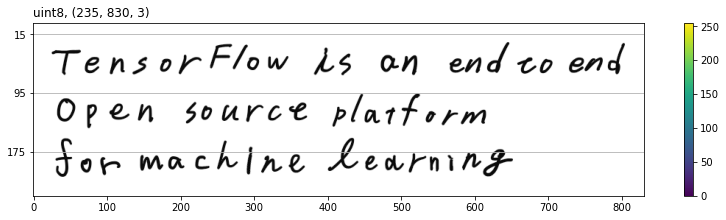

In [6]:
# 3-3 이미지 로드 결과보기
# (235, 830, 3)
def compatible_image(img):
    if img.ndim == 3 and img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
    return img

# 이미지를 차트로 보자 (글자의 높이 확인)
def show_image(img, y_offset=0, y_steps=None, colorbar=True):
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(12, 3))
    plt.imshow(compatible_image(img))
    plt.title("{}, {}".format(img.dtype, img.shape), fontsize=12, loc="left")
    
    if y_steps:
        plt.yticks(np.arange(y_offset, img.shape[0] + 1, y_steps))
        plt.grid(True, axis="y")
        
    if colorbar:
        plt.colorbar()
    plt.tight_layout()
    plt.show()
    
show_image(img_letter, y_offset=15, y_steps=80)

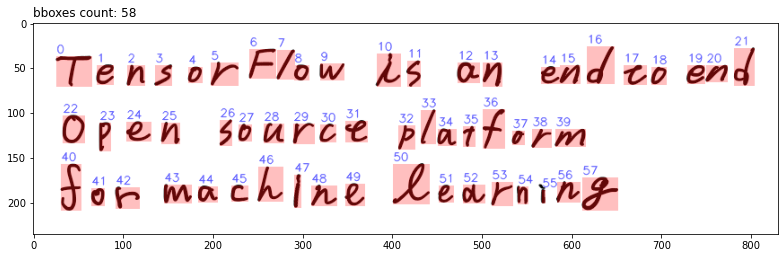

In [21]:
# 3-4 이미지에서 문자를 추출 : 연산 메소드

# 글자 추출한 것을 병합 : 유사한 박스(이미지 내에 글자)를 병합
def merge_bboxes(bboxes, threshold, min_size=2, max_size=65):
    # 사각형 크기가 min / max 에 맞지 않은 대상은 생략
    targets = filter(
        # x[0]=x, x[1]=y, x[2]=w, x[3]=h
        lambda x: min_size <= x[2] <= max_size and min_size <= x[3] <= max_size,
        bboxes,
    )
    
    # x[0]=x, x[1]=y, x[2]=w, x[3]=h
    results = []
    for bbox in targets:
        like_bbox = list(
            filter(
                lambda x: x[0] - threshold <= bbox[0] <= x[0] + threshold
                and x[1] - threshold <= bbox[1] <= x[1] + threshold
                and x[2] - threshold <= bbox[2] <= x[2] + threshold
                and x[3] - threshold <= bbox[3] <= x[3] + threshold,
                results,
            )
        )       
        if like_bbox == []:
            results.append(bbox)
    return results

# 3-5 이미지에서 글자를 추출해서 박스로 영역을 잡는다
def detect_bboxes(img, y_offset, y_steps, delta=10, min_area=2, max_area=400):
    mser = cv2.MSER_create()   # 문자영역을 감지하는 클래스
    mser.setDelta(delta)
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setPass2Only(True)  
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    
    msers, bboxes = mser.detectRegions(gray)   # gray라는 대상이미지에 문자를 감지 후 리턴
    unique_bboxes = merge_bboxes(bboxes, threshold=16)   # 감지한 이미지를 병합하는 함수
    
    img_width = gray.shape[1]
    # 이미지에서 글자를 추출해 merge_bboxes로 병합해서 리턴을 받게되면 순서가 무작위로 리턴된다
    # 왼쪽에서 오른쪽으로 정렬. 단락번호 (0,1,2,3,,,,)
    # X 가로 폭 + X 좌표의 오름차순으로 정렬
    unique_bboxes.sort(key=lambda b: int((b[1] - y_offset) / y_steps) * img_width + b[0])
    return unique_bboxes

# 각 문자의 범위가 추출이 된다
bboxes = detect_bboxes(img_letter, y_offset=10, y_steps=66)

# 3-6 원본 이미지를 글자만 추출해서 리턴한 이미지를 가져다가 2장으로 복사를 한다
# 한 장은 이미지 영역을 한 장은 이미지 위에 숫자를 출력 하도록 한 후 확인
def show_bboxes(img, bboxes, alpha=0.25):  
    vis, overlay = img.copy(), img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox   # 좌표 가로세로 크기값
        # 이미지 글자에 핑크 박스를 입힌다.
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0xFF, 0x00, 0), thickness=-1)
        # 이미지 위에 숫자를 쓴다
        cv2.putText(vis, str(i), (x, y - 4), font, 0.42, (0, 0, 0xFF), 1, cv2.LINE_AA)
    
    # 두 개의 이미지가 합해진다
    vis = cv2.addWeighted(overlay, alpha + 0.1, vis, 1 - alpha, 0)
    
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(11, 4))
    plt.imshow(compatible_image(vis))
    plt.title("bboxes count: {}".format(len(bboxes)), fontsize=12, loc="left")
    plt.tight_layout()
    plt.show()

    
show_bboxes(img_letter, bboxes)

# 3-7 이미지 자르기
def crop_image(img, bbox, target_size, padding, expand=1):
    x, y, w, h = bbox
    # 이미지 틀
    crop = tf.image.crop_to_bounding_box(
        img, y - expand, x - expand, h + (expand * 2), w + (expand * 2)
    )    
    
    # 영역 채우기
    iw, ih, _ = crop.shape
    edge_len = tf.reduce_max([iw, ih]) + (padding * 2)  
    crop = tf.image.resize_with_crop_or_pad(crop, edge_len, edge_len)
    
    # 이미지 재조정
    method = tf.image.ResizeMethod.MITCHELLCUBIC
    crop = tf.image.resize(crop, [target_size, target_size], method=method)
    return crop

def setup_data(img, bboxes, target_size=28, padding=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    gray = gray.astype("float32")
    gray = gray / 255.0
    gray = np.expand_dims(gray, 2) 
    crop_images = []
    for i, bbox in enumerate(bboxes):
        crop_images.append(crop_image(gray, bbox, target_size, padding))    
    return np.array(crop_images)

crop_images = setup_data(img_letter, bboxes)

(58, 28, 28, 1)


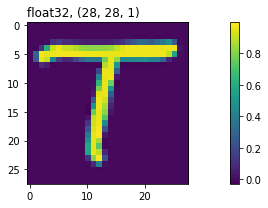

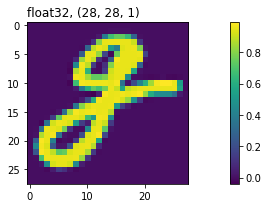

In [23]:
print(crop_images.shape)
show_image(crop_images[0])
show_image(crop_images[57])

In [24]:
model = keras.models.load_model('my-model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 64)         

In [25]:
predictions = model.predict(crop_images)
print(predictions)   # 예측률

[[1.07635517e-14 3.77103570e-04 2.65691119e-06 ... 7.46494493e-07
  7.61656793e-06 1.11720851e-06]
 [3.00715082e-20 6.00922689e-08 7.00727014e-08 ... 1.71697032e-11
  4.92390816e-11 4.51211513e-09]
 [5.59458358e-15 4.83533768e-05 1.18584740e-06 ... 4.41293423e-06
  4.38641024e-07 2.42928451e-08]
 ...
 [1.37595750e-14 1.88367579e-07 1.18205845e-08 ... 1.55486859e-08
  4.25701359e-07 4.65766909e-08]
 [2.88723406e-10 2.96673272e-03 5.35924046e-05 ... 7.76064815e-04
  3.19973660e-05 2.84136222e-05]
 [2.63219685e-22 5.92468865e-08 2.85846404e-08 ... 4.12016775e-13
  1.07242920e-06 4.58048953e-06]]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ' ', 10, 11, ' ', 12, 13, ' ', 14, 15, 16, ' ', 17, 18, ' ', 19, 20, 21, ' ', 22, 23, 24, 25, ' ', 26, 27, 28, 29, 30, 31, ' ', 32, 33, 34, 35, 36, 37, 38, 39, ' ', 40, 41, 42, ' ', 43, 44, 45, 46, 47, 48, 49, ' ', 50, 51, 52, 53, 54, 55, 56, 57]
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'I', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'I', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


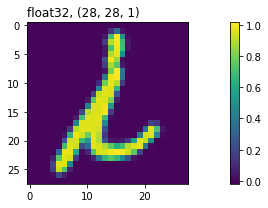

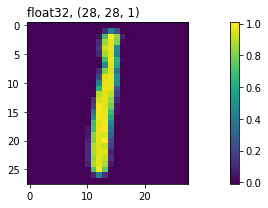

In [27]:
# 학습 된 모델을 사용하여 잘라낸 이미지를 예측
class_names =list(" ABCDEFGHIJKLMNOPQRSTUVWXYZ")
true_msg = list("TENSORFLOWISANENDTOENDOPENSOURCEPLATFORMFORMACHINELEARNING")
split_pos = [9, 11, 13, 16, 18, 21, 25, 31, 39, 42, 49]
pred_msg, corr_msg , errors =[],[],[] 

for  i, pred in enumerate(predictions): 
    pred_str = class_names[np.argmax(pred)]
    pred_msg.append(i)
    
    if pred_str != true_msg[i]:
        corr_msg.append(true_msg[i])
        errors.append(i)
        
    else:
        corr_msg.append(" ")
        
    if  i  in split_pos:
        pred_msg.append(" ")
        corr_msg.append(" ")
        
print("".join(str(pred_msg)))
print("". join(str(corr_msg)))

for  i in errors:
    show_image(crop_images[i]) 

In [ ]:
# 입력된 이미지 중에 영문자 아이와 엘이 잘못된 글자로 인식된 것을 확인
# 앞으로도 인식을 못할 것이다.

In [69]:
# 3-4 컬러로 이미지를 읽어온다
img_letter = cv2.imread('C:\\Users\\user\\MyPython\\img\\c_test.png', cv2.IMREAD_COLOR)

# 3-5 흑백으로 이미지를 변환한다
img_letter_gray = cv2.cvtColor(img_letter, cv2.COLOR_BGR2GRAY)

# 3-6 cv2.MSER_create() 클래스를 선언한다.
mser = cv2.MSER_create()

# 3-7 mser.detectRegions(흑백이미지) => 오브젝트 위치를 구한다
reg, _ = mser.detectRegions(img_letter_gray)

# 3-8 해당 이미지의 오브젝트 위치에 바운드 박스를 그린다
img_copy = img_letter.copy()

for r in reg:
    (x , y, w, h) = cv2.boundingRect(np.reshape(r,(-1,1,2)))
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0,0,255),1)
    
print(img_copy)

# cv2.imshow('mser', img_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[[[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 [[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 [[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 ...

 [[212 219 222]
  [211 218 221]
  [209 216 219]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]

 [[214 221 224]
  [213 220 223]
  [211 218 221]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]

 [[215 222 225]
  [214 221 224]
  [213 220 223]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]]
